In [3]:
%pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc pandas scikit-learn chembl_webresource_client
#conda install -c conda-forge rdkit

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# ===============================================
# STEP 0: Load molecular activity dataset (ChEMBL)
# ===============================================

target = new_client.target
activity = new_client.activity

target_query = target.search("EGFR kinase")  # example: EGFR inhibition dataset
target_id = target_query[0]['target_chembl_id']
activities = activity.filter(
    target_chembl_id=target_id,
    standard_type="IC50",
    limit=1000
)

data = pd.DataFrame.from_records([a for a in activities])
selected_data = data[['canonical_smiles', 'standard_value']].dropna()

# Convert IC50 to numeric
selected_data['standard_value'] = pd.to_numeric(selected_data['standard_value'], errors='coerce')
selected_data.dropna(subset=['standard_value'], inplace=True)

# ===============================================
# STEP 1: SMILES → Morgan Fingerprint → X, y
# ===============================================

def smiles_to_fingerprints(smiles, size=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=size))
    return None

selected_data['fingerprint'] = selected_data['canonical_smiles'].apply(smiles_to_fingerprints)
filtered_data = selected_data.dropna(subset=['fingerprint'])

# IC50 threshold: Active if < 1000 nM
filtered_data['activity'] = filtered_data['standard_value'].apply(lambda x: 1 if x < 1000 else 0)

X = np.vstack(filtered_data['fingerprint'].values)
y = filtered_data['activity'].values.astype(int)

print("Original dataset:", X.shape, "labels:", np.unique(y, return_counts=True))

# ===============================================
# STEP 2: Balanced subset 
# ===============================================

active_idx = np.where(y == 1)[0]
inactive_idx = np.where(y == 0)[0]

subset = min(len(active_idx), len(inactive_idx), 60)  # optional control
selected_idx = np.concatenate([
    np.random.choice(active_idx, size=subset, replace=False),
    np.random.choice(inactive_idx, size=subset, replace=False)
])

X = X[selected_idx]
y = y[selected_idx]

print("After balancing:", X.shape, np.unique(y, return_counts=True))

# ===============================================
# STEP 3: PCA feature reduction 
# ===============================================

num_components = 20
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=num_components)
X = pca.fit_transform(X_scaled)

print("PCA variance retained:", np.sum(pca.explained_variance_ratio_))
print("After PCA:", X.shape)

# ===============================================
# STEP 4: Scale features to [-pi, pi]
# ===============================================

X_min = X.min()
X_max = X.max()
X = (X - X_min) / (X_max - X_min) * 2 * np.pi

# ===============================================
# STEP 5: Train/Test Split
# ===============================================

X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, train_size=60, test_size=30, random_state=42, stratify=y
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("Train dist:", np.unique(train_labels, return_counts=True))
print("Test dist:", np.unique(test_labels, return_counts=True))


Original dataset: (24344, 2048) labels: (array([0, 1]), array([ 7640, 16704]))
After balancing: (120, 2048) (array([0, 1]), array([60, 60]))
PCA variance retained: 0.3790619241765279
After PCA: (120, 20)
X_train: (60, 20) X_test: (30, 20)
Train dist: (array([0, 1]), array([30, 30]))
Test dist: (array([0, 1]), array([15, 15]))


In [26]:
from qiskit.circuit.library import efficient_su2


num_features = np.shape(X_train)[1]
num_qubits = num_features
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.

from qiskit.circuit.library import PauliFeatureMap
fm = PauliFeatureMap(num_qubits, reps=1, paulis=['Z' 'ZZ'])


training done
test matrix done


Text(0.5, 1.0, 'test matrix')

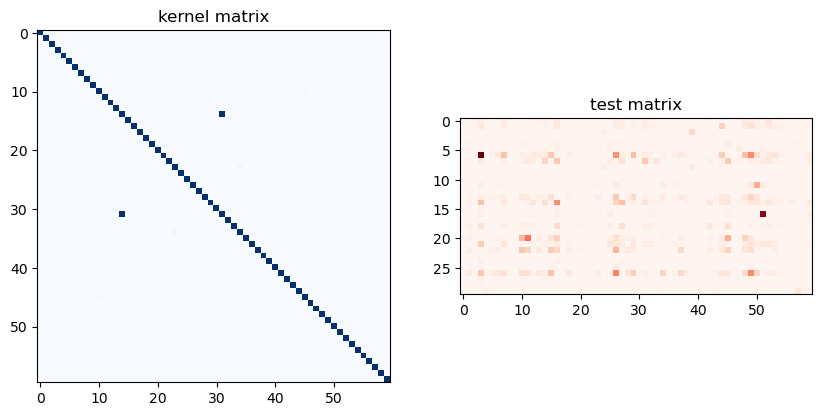

In [27]:
# Empty kernel matrix
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

# To use a simulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import unitary_overlap
 
num_shots = 10000

sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

# Visualisation Imports
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("kernel matrix")

axs[1].imshow(np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("test matrix")

In [28]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_train_kernel = qml_svc.score(kernel_matrix, train_labels)
print(f"Quantum SVC classification training accuracy: {qml_score_train_kernel}")
qml_score_test_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Quantum SVC classification test accuracy: {qml_score_test_kernel}")

Quantum SVC classification training accuracy: 1.0
Quantum SVC classification test accuracy: 0.5


In [5]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, train_labels)  # suppress printing the return value
train_score_c = svc.score(X_train, train_labels)
test_score_c = svc.score(X_test, test_labels)


print(f"Classical SVC training accuracy: {train_score_c:.2f}")
print(f"Classical SVC test accuracy:     {test_score_c:.2f}")

Classical SVC training accuracy: 0.82
Classical SVC test accuracy:     0.77


In [6]:
from sklearn.svm import SVC

kernels = ["linear", "poly", "rbf", "sigmoid"]
results = {}

for k in kernels:
    svc = SVC(kernel=k)
    svc.fit(X_train, train_labels)

    train_acc = svc.score(X_train, train_labels)
    test_acc = svc.score(X_test, test_labels)

    results[k] = (train_acc, test_acc)

# 결과 출력
print("=== Classical SVC Kernel Comparison ===")
for k, (tr, te) in results.items():
    print(f"Kernel = {k:<7} | Train Acc = {tr:.2f} | Test Acc = {te:.2f}")

=== Classical SVC Kernel Comparison ===
Kernel = linear  | Train Acc = 0.78 | Test Acc = 0.73
Kernel = poly    | Train Acc = 0.93 | Test Acc = 0.67
Kernel = rbf     | Train Acc = 0.82 | Test Acc = 0.77
Kernel = sigmoid | Train Acc = 0.47 | Test Acc = 0.50
